# Domande
1. Calcolo psf dati (come?)

2. capire quali stelle hanno sharpness negativa (magnitudine, nr fotoni)
3. correlazione $\sigma_{x}, \sigma_{y}, \theta$ con stelle sharpness < 0

Under the modern logarithmic magnitude scale, two objects, one of which is used as a reference or baseline, whose intensities (brightnesses) measured from Earth in units of power per unit area (such as watts per square metre, $W\cdot m^{-2}$) are $I_{1}$ and $I_{ref}$, will have magnitudes $m_{1}$ and $m_{ref}$ related by:

$$m_{1} - m_{ref}= -2.5 \cdot log(\frac{I_{1}}{I_{ref}}) \Rightarrow I_{1} = I_{ref}e^{(-\frac{m_{1}-m_{ref}}{2.5})}$$
with:
<br>$m_{ref} = m_{Vega}=0$

$I_{ref}= I_{Vega}=K$

# Importazione moduli

In [37]:
import numpy as np 
import pandas as pd
import seaborn as sns
from astropy.modeling import models, fitting
from itertools import combinations
from astropy.io import fits
import sys
sys.path.append('../lib')
from utils import *
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# Lettura dataset

In [38]:
names = ['ID', 'Xcor','Ycor', 'F606','eF606','F814','eF814','chi','sharp']
file = "hlsp_deep47tuc_hst_acs_47tuc_f606w-f814w_v1_catalog.txt"
filepath = '../Data/Catalog/'

data = pd.read_csv(
    filepath + file,
    names=names,
    delim_whitespace=True,
    skiprows=1
    )
data

ID      Xcor       Ycor    F606   eF606    F814   eF814     chi  \
0           8  4462.947    140.859  28.197  0.1036  27.127  0.1068   6.106   
1         120  5002.486    186.138  20.843  0.0552  19.815  0.0661  10.690   
2         165  5003.574    195.421  27.014  0.2194  26.068  0.1349  10.651   
3         226  4448.493    207.417  30.193  0.3641  28.270  0.1636   4.059   
4         351  5040.717    224.366  28.935  0.1669  28.941  0.2464   4.274   
...       ...       ...        ...     ...     ...     ...     ...     ...   
51475  899987  3417.467  10394.319  26.895  0.0783  25.602  0.1050   9.508   
51476  900088  3435.031  10396.730  23.152  0.0504  22.662  0.0505   8.823   
51477  900094  3594.567  10397.340  27.209  0.0815  27.130  0.0900   4.311   
51478  900176  5155.093  10397.920  28.235  0.0984  26.477  0.0937   6.173   
51479  900218  5658.604  10399.720  24.898  0.0349  24.198  0.0752   8.477   

        sharp  
0      0.7310  
1      0.4000  
2      0.1940  
3     -1.9585  
4     -0.7720  
...       ...  
51475  1.3140  
51476 -0.1330  
51477  0.9355  
51478  0.3190  
51479  0.7300  

[51480 rows x 9 columns]

In [39]:
cols = data.columns[3:]
pairs = list(combinations(cols, 2))
pairs

[('F606', 'eF606'),
 ('F606', 'F814'),
 ('F606', 'eF814'),
 ('F606', 'chi'),
 ('F606', 'sharp'),
 ('eF606', 'F814'),
 ('eF606', 'eF814'),
 ('eF606', 'chi'),
 ('eF606', 'sharp'),
 ('F814', 'eF814'),
 ('F814', 'chi'),
 ('F814', 'sharp'),
 ('eF814', 'chi'),
 ('eF814', 'sharp'),
 ('chi', 'sharp')]

In [40]:
from sklearn.feature_selection import mutual_info_regression

MIs = []
for pair in pairs: 
    f1, f2 = pair 
    x1 = data[f1].to_numpy().reshape(-1, 1)
    x2 = data[f2].to_numpy()
    MIs.append(mutual_info_regression(x1, x2))
    
MIs = np.array(MIs).flatten()

In [41]:
MIs

array([0.70812376, 2.72526685, 0.53885379, 0.23846063, 0.45863538,
       0.63088918, 1.15140175, 0.48245338, 0.56161807, 0.71415348,
       0.237097  , 0.46835612, 0.49889737, 0.55204236, 0.34506369])

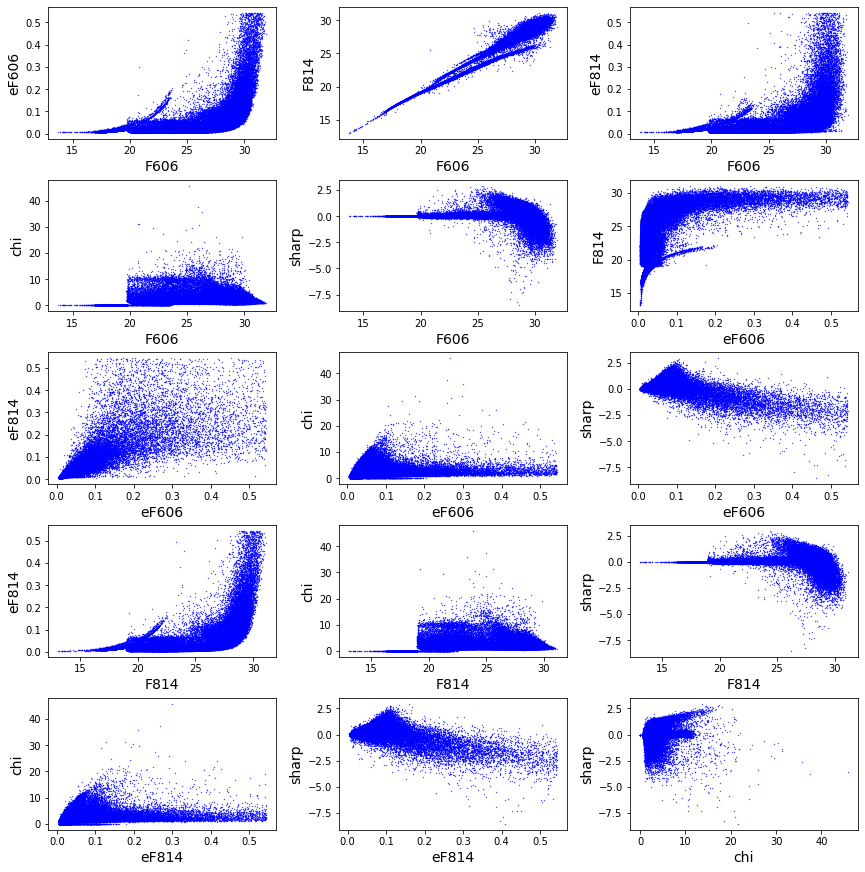

In [42]:
fig, axs = plt.subplots(5, 3, figsize=(12, 12), constrained_layout=True)
axs = axs.flatten()

for ax, pair in zip(axs, pairs):
    f1, f2 = pair 
    x1 = data[f1].to_numpy()
    x2 = data[f2].to_numpy()
    
    ax.scatter(x1, x2, s=0.1, c='b')
    ax.set_xlabel(f1)
    ax.set_ylabel(f2)

    filepath_images = '../Images/'
    file = f'{f1}_vs_{f2}.png'
    #plt.savefig(filepath_images + file, dpi=1000)

plt.show()
plt.close()

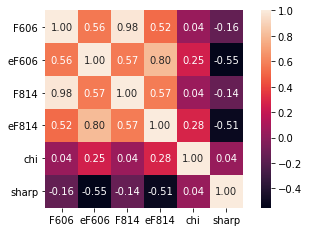

In [43]:
cols = data.columns[3:]


cm = np.corrcoef(data[cols].to_numpy().T)
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 10},
                 yticklabels=cols,
                 xticklabels=cols)
plt.tight_layout()
plt.show()

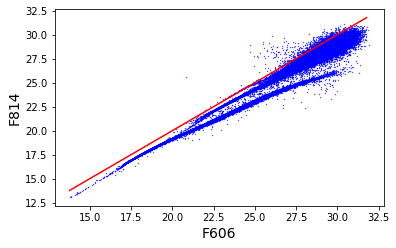

In [44]:
plt.close()
ax = latex_settings()

x = np.arange(data.F606.min(), data.F606.max())

ax.scatter(data.F606, data.F814, s=0.1, c='b')
ax.plot(x, x, c='r')
#ax.set_xlim(33, 13.5)
#ax.set_ylim(31.5, 12.5)
ax.set_xlabel('F606')
ax.set_ylabel('F814')

filepath_images = '../Images/'
file = 'F814_vs_F606.png'
#plt.savefig(filepath_images + file, dpi=1000)

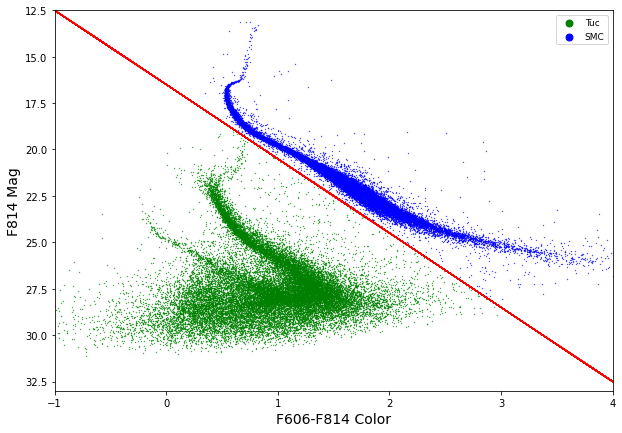

In [52]:
x = data.F606 - data.F814
y = 16.5 + 4. * x

Tuc = data.F814 > y
SMC = data.F814 < y

plt.figure(figsize=(10,7))
plt.plot(x, y, '-r', lw=1)
plt.scatter(x[Tuc], data.loc[Tuc, 'F814'], s=0.1, c='g', label='Tuc')
plt.scatter(x[SMC], data.loc[SMC, 'F814'], s=0.1, c='b', label='SMC')
plt.xlim(-1, 4)
plt.ylim(33, 12.5)
plt.xlabel('F606-F814 Color')
plt.ylabel('F814 Mag')
leg = plt.legend()
plt.legend(markerscale=22)

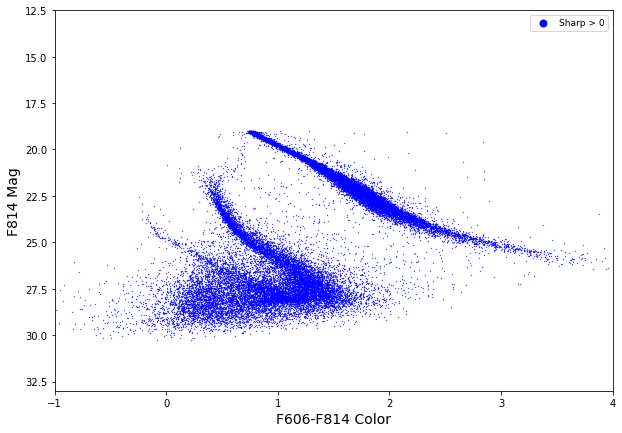

In [60]:
Sharp = data.sharp == 0
Shar_pos = data.sharp > 0
Sharp_neg = data.sharp < 0

plt.figure(figsize=(10,7))
#plt.scatter(x[Sharp], data.loc[Sharp, 'F814'], s=0.1, c='g', label='Sharp = 0')
#plt.scatter(x[Sharp_neg], data.loc[Sharp_neg, 'F814'], s=0.1, c='y', label='Sharp < 0')
plt.scatter(x[Shar_pos], data.loc[Shar_pos, 'F814'], s=0.1, c='b', label='Sharp > 0')

plt.xlim(-1, 4)
plt.ylim(33, 12.5)
plt.xlabel('F606-F814 Color')
plt.ylabel('F814 Mag')
plt.legend(markerscale=22);

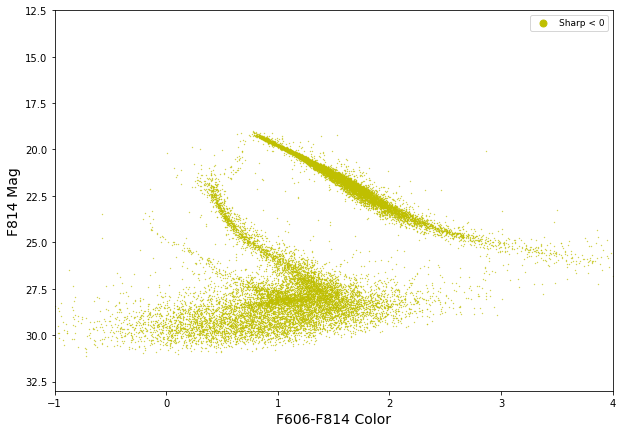

In [59]:
Sharp = data.sharp == 0
Shar_pos = data.sharp > 0
Sharp_neg = data.sharp < 0

plt.figure(figsize=(10,7))
#plt.scatter(x[Sharp], data.loc[Sharp, 'F814'], s=0.1, c='g', label='Sharp = 0')
plt.scatter(x[Sharp_neg], data.loc[Sharp_neg, 'F814'], s=0.1, c='y', label='Sharp < 0')
#plt.scatter(x[Shar_pos], data.loc[Shar_pos, 'F814'], s=0.1, c='b', label='Sharp > 0')

plt.xlim(-1, 4)
plt.ylim(33, 12.5)
plt.xlabel('F606-F814 Color')
plt.ylabel('F814 Mag')
plt.legend(markerscale=22);

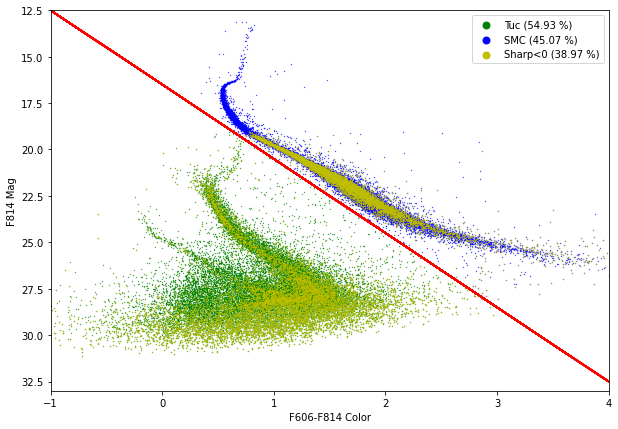

In [12]:
x = data.F606 - data.F814
y = 16.5 + 4. * x
plt.figure(figsize=(10,7))
plt.plot(x, y, '-r')

Tuc = np.where(data.F814 > y)[0]
SMC = np.where(data.F814 < y)[0]
Shar = np.where(data.sharp == 0)[0]
Shar_neg = np.where(data.sharp < 0)[0]
Chi = np.where(data.chi == 0)[0]

perc = np.array([len(Tuc), len(SMC), len(Shar), len(Shar_neg), len(Chi)]) * 100 / len(x)

plt.scatter(x[Tuc], data.loc[Tuc, 'F814'], s=0.1, c='g', label='Tuc ({:.2f} %)'.format(perc[0]))
plt.scatter(x[SMC], data.loc[SMC, 'F814'], s=0.1, c='b', label='SMC ({:.2f} %)'.format(perc[1]))
#plt.scatter(x[Shar], data.loc[Shar, 'F814'], s=0.1, c='k', label='Sharp=0 ({:.2f} %)'.format(perc[2]))
plt.scatter(x[Shar_neg], data.loc[Shar_neg, 'F814'], s=0.1, c='y', label='Sharp<0 ({:.2f} %)'.format(perc[3]))
#plt.scatter(x[Chi], data.loc[Chi, 'F814'], s=0.1, c='m', label='Chi=0 ({:.2f} %)'.format(perc[4]))

plt.xlim(-1, 4)
plt.ylim(33, 12.5)
plt.xlabel('F606-F814 Color')
plt.ylabel('F814 Mag')
plt.legend(markerscale=22);

# Istogramma dei valori della magnitudine per sharpness < 0

<AxesSubplot:ylabel='Frequency'>

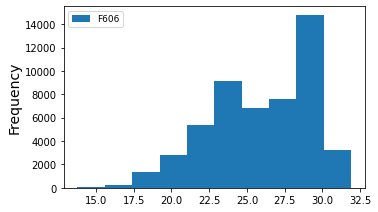

In [64]:
data[['F606']].plot(kind='hist')

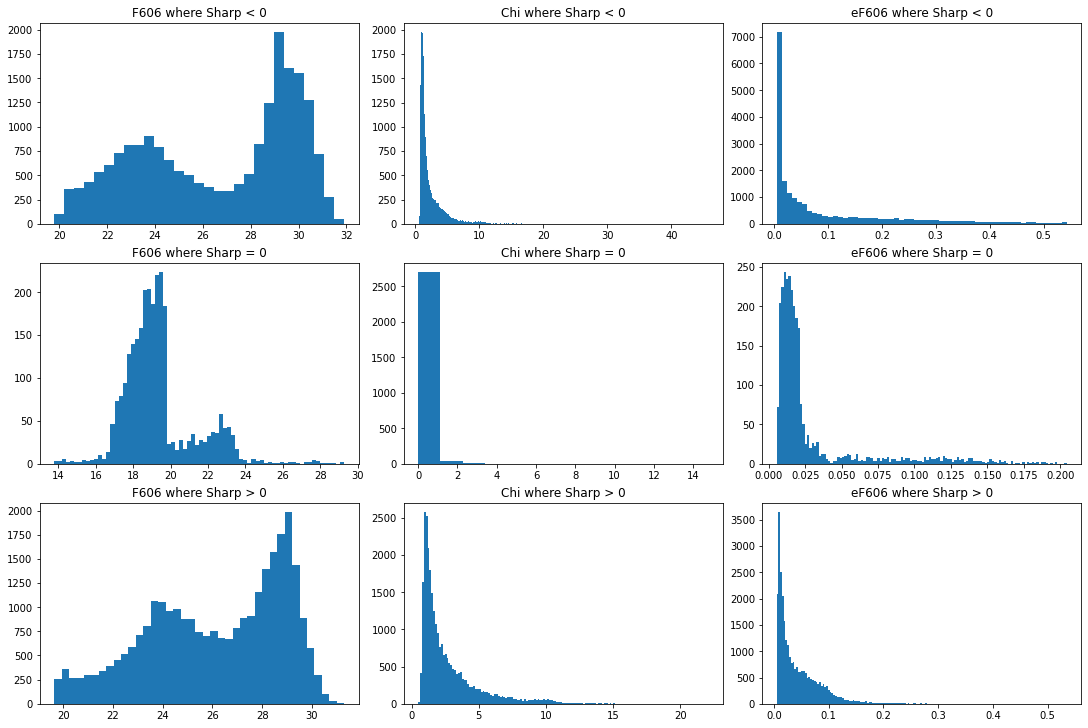

In [65]:
fig, axs = plt.subplots(3, 3, figsize=(15,10), constrained_layout=True)

axs[0,0].hist(data.loc[data.sharp < 0, 'F606'], bins='auto')
axs[0,0].set_title("F606 where Sharp < 0")

axs[1,0].hist(data.loc[data.sharp == 0, 'F606'], bins='auto')
axs[1,0].set_title("F606 where Sharp = 0")

axs[2,0].hist(data.loc[data.sharp > 0, 'F606'], bins='auto')
axs[2,0].set_title("F606 where Sharp > 0")

axs[0,1].hist(data.loc[data.sharp < 0, 'chi'], bins='auto')
axs[0,1].set_title("Chi where Sharp < 0")

axs[1,1].hist(data.loc[data.sharp == 0, 'chi'], bins='auto')
axs[1,1].set_title("Chi where Sharp = 0")

axs[2,1].hist(data.loc[data.sharp > 0, 'chi'], bins='auto');
axs[2,1].set_title("Chi where Sharp > 0")

axs[0,2].hist(data.loc[data.sharp < 0, 'eF606'], bins='auto')
axs[0,2].set_title("eF606 where Sharp < 0")

axs[1,2].hist(data.loc[data.sharp == 0, 'eF606'], bins='auto')
axs[1,2].set_title("eF606 where Sharp = 0")

axs[2,2].hist(data.loc[data.sharp > 0, 'eF606'], bins='auto');
axs[2,2].set_title("eF606 where Sharp > 0");

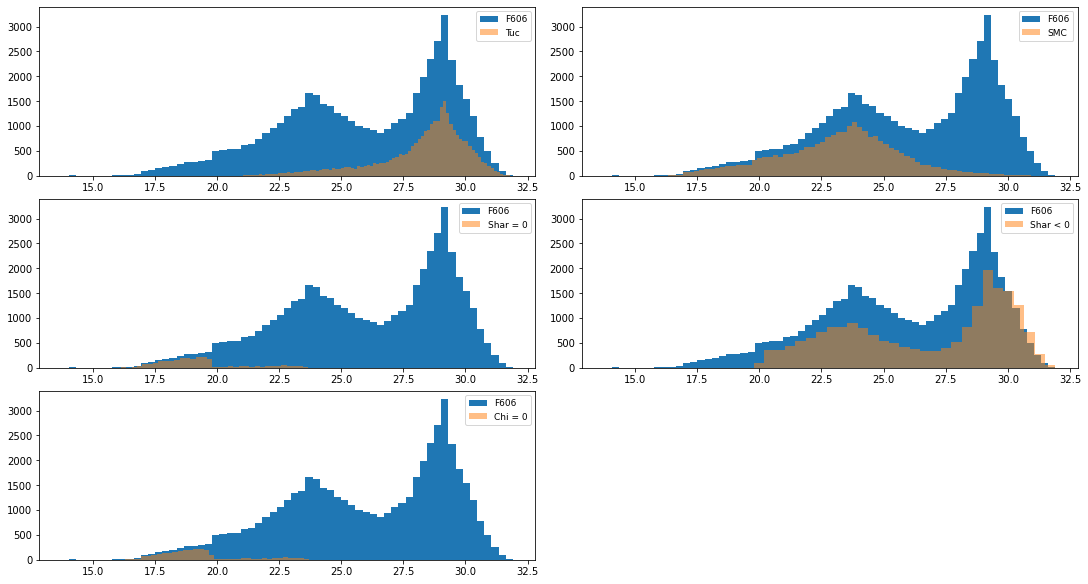

In [66]:
def trim_axs(axs, N):
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

fig, axs = plt.subplots(3, 2, figsize=(15,8), constrained_layout=True)
axs = trim_axs(axs, 5)

Tuc = np.where(data.F814 > y)[0]
SMC = np.where(data.F814 < y)[0]
Shar = np.where(data.sharp == 0)[0]
Shar_neg = np.where(data.sharp < 0)[0]
Chi = np.where(data.chi == 0)[0]

axs[0].hist(data['F606'], bins='auto', label='F606')
axs[0].hist(data.loc[Tuc, 'F606'], bins='auto', alpha=0.5, label='Tuc');
axs[0].legend();

axs[1].hist(data['F606'], bins='auto', label='F606')
axs[1].hist(data.loc[SMC, 'F606'], bins='auto', alpha=0.5, label='SMC');
axs[1].legend();

axs[2].hist(data['F606'], bins='auto', label='F606')
axs[2].hist(data.loc[Shar, 'F606'], bins='auto', alpha=0.5, label='Shar = 0');
axs[2].legend();

axs[3].hist(data['F606'], bins='auto', label='F606')
axs[3].hist(data.loc[Shar_neg, 'F606'], bins='auto', alpha=0.5, label='Shar < 0');
axs[3].legend();

axs[4].hist(data['F606'], bins='auto', label='F606')
axs[4].hist(data.loc[Chi, 'F606'], bins='auto', alpha=0.5, label='Chi = 0');
axs[4].legend();

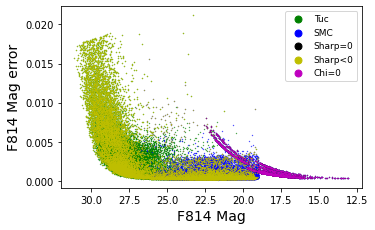

In [67]:
plt.scatter(data.F814[Tuc], data.eF814[Tuc] / data.F814[Tuc], s=0.1, c='g', label='Tuc')
plt.scatter(data.F814[SMC], data.eF814[SMC] / data.F814[SMC], s=0.1, c='b', label='SMC')
plt.scatter(data.F814[Shar], data.eF814[Shar] / data.F814[Shar], s=0.1, c='k', label='Sharp=0')
plt.scatter(data.F814[Shar_neg], data.eF814[Shar_neg] / data.F814[Shar_neg], s=0.1, c='y', label='Sharp<0')
plt.scatter(data.F814[Chi], data.eF814[Chi] / data.F814[Chi], s=0.1, c='m', label='Chi=0')

plt.gca().invert_xaxis()
plt.xlabel('F814 Mag')
plt.ylabel('F814 Mag error')
plt.legend(markerscale=22);

errore cresce in quanto il conteggio dei fotoni si basa su una statistica poissoniana, di conseguenza le stelle 
che si trovano a destra dell'asse x hanno un errore maggiore in quanto i fotoni rilevati sono pochi.

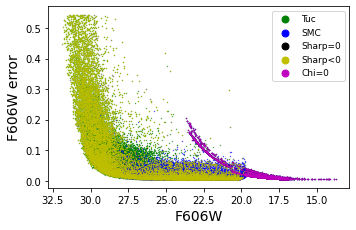

In [69]:
plt.scatter(data.F606[Tuc], data.eF606[Tuc], s=0.1, c='g', label='Tuc')
plt.scatter(data.F606[SMC], data.eF606[SMC], s=0.1, c='b', label='SMC')
plt.scatter(data.F606[Shar], data.eF606[Shar], s=0.1, c='k', label='Sharp=0')
plt.scatter(data.F606[Shar_neg], data.eF606[Shar_neg], s=0.1, c='y', label='Sharp<0')
plt.scatter(data.F606[Chi], data.eF606[Chi], s=0.1, c='m', label='Chi=0')


plt.gca().invert_xaxis()
plt.ylabel('F606W error')
plt.xlabel('F606W')
plt.legend(markerscale=22);

I dati del dataset sono stati ottenuti da più immagini, ma quelli presenti sul bordo risultano essere meno precisi in quanto sono ottenuti da poche immagini. 
Inoltre i dati sono stati anche pre processati

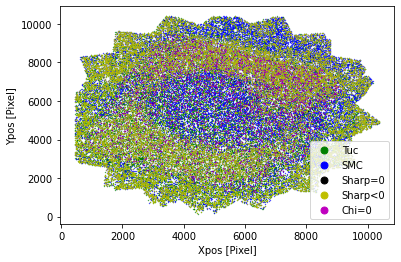

In [19]:
plt.scatter(data.Xcor[Tuc], data.Ycor[Tuc], s=0.1, c='g', label='Tuc')
plt.scatter(data.Xcor[SMC], data.Ycor[SMC], s=0.1, c='b', label='SMC')
plt.scatter(data.Xcor[Shar], data.Ycor[Shar], s=0.1, c='k', label='Sharp=0')
plt.scatter(data.Xcor[Shar_neg], data.Ycor[Shar_neg], s=0.1, c='y', label='Sharp<0')
plt.scatter(data.Xcor[Chi], data.Ycor[Chi], s=0.1, c='m', label='Chi=0')

plt.xlabel('Xpos [Pixel]')
plt.ylabel('Ypos [Pixel]')
plt.legend(markerscale=22);

La sharpness negativa è una cosa poco chiara, in quanto la sharpness indica quanto è nitida una stella ed è caratteristica dello strumento.

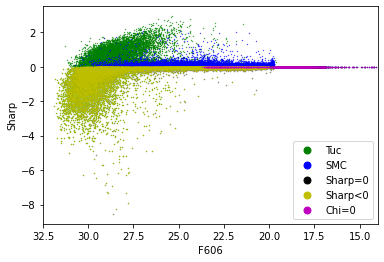

In [20]:
plt.scatter(data.F606[Tuc], data.sharp[Tuc], s=0.1, c='g', label='Tuc')
plt.scatter(data.F606[SMC], data.sharp[SMC], s=0.1, c='b', label='SMC')
plt.scatter(data.F606[Shar], data.sharp[Shar], s=0.1, c='k', label='Sharp=0')
plt.scatter(data.F606[Shar_neg], data.sharp[Shar_neg], s=0.1, c='y', label='Sharp<0')
plt.scatter(data.F606[Chi], data.sharp[Chi], s=0.1, c='m', label='Chi=0')

plt.xlabel('F606')
plt.ylabel('Sharp')
plt.legend(markerscale=22)
plt.xlim(32.5, 14);

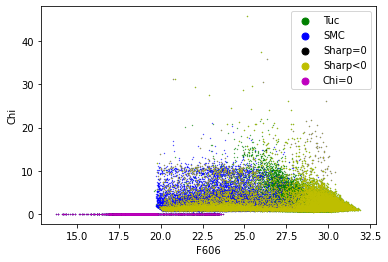

In [21]:
plt.scatter(data.F606[Tuc], data.chi[Tuc], s=0.1, c='g', label='Tuc')
plt.scatter(data.F606[SMC], data.chi[SMC], s=0.1, c='b', label='SMC')
plt.scatter(data.F606[Shar], data.chi[Shar], s=0.1, c='k', label='Sharp=0')
plt.scatter(data.F606[Shar_neg], data.chi[Shar_neg], s=0.1, c='y', label='Sharp<0')
plt.scatter(data.F606[Chi], data.chi[Chi], s=0.1, c='m', label='Chi=0')


plt.xlabel('F606')
plt.ylabel('Chi')
plt.legend(markerscale=22);

I dati che presentano un valori di chi quadro pari a zero sono stelle speciali, in quanto sono stelle che sono state ottenute da simulazioni.

Considerando le stelle in verde, bisogna determinare quali sono.

individuare stelle con sharpness negativa di entrambi i gruppi di stelle. 


Vedere in che modo cambia la pfs per stelle di diverse magnitudini.

# F606W

In [23]:
# Open the FITS file of F606W
fits_file = 'hlsp_deep47tuc_hst_acs_47tuc_f606w_v1_drz.fits'
fits_f606w = fits.open('../Data/FITS/' + fits_file)

# Data is stored as a 2-D numpy array
image_data_f606w = fits_f606w[0].data

# info about fits file
fits_f606w.info()

Filename: ../Data/FITS/hlsp_deep47tuc_hst_acs_47tuc_f606w_v1_drz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    7127   (10510, 10403)   float32   


Generally the image information is located in the PRIMARY block. The blocks are numbered and can be accessed by indexing.

In [27]:
# header
fits_f606w[0].header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                10510 / Axis length                                    
NAXIS2  =                10403 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2010-11-13T23:39:37' / Date FITS file was generated                  
IRAF-TLM= '2010-11-13T23:39:14' / Time of last modification                     
NEXTEND =                    3 / Number of standard extensions                  
FILENAME= 'final_drz.fits'     / name of file                                   
FILETYPE= 'SCI      '          / type of data found in data file                
                            

Close the FITS file. The data is stored in image_data.

In [28]:
fits_f606w.close()

Viewing the image data and getting basic statistics

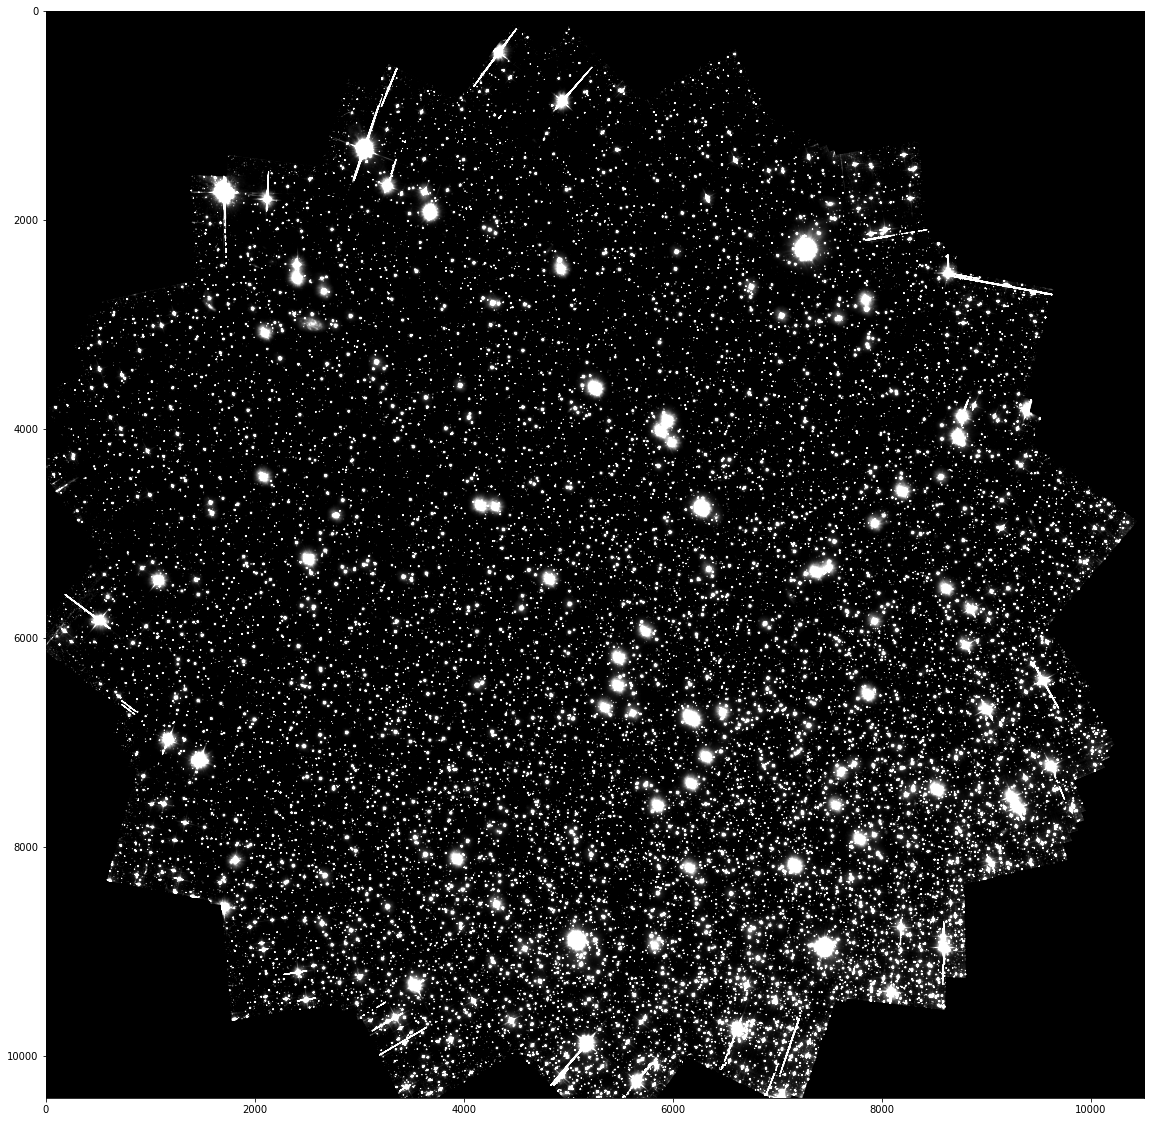

In [29]:
plt.figure(figsize = (20,20))
plt.imshow(image_data_f606w, cmap='gray', vmin=10, vmax=300);

# F814W

In [33]:
# Open the FITS file of F606W
fits_file = 'hlsp_deep47tuc_hst_acs_47tuc_f814w_v1_drz.fits'
fits_f814w = fits.open('../Data/FITS/' + fits_file)

image_data_f814w = fits_f814w[0].data

fits_f814w.info()

Filename: ../Data/FITS/hlsp_deep47tuc_hst_acs_47tuc_f814w_v1_drz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    7595   (10065, 10395)   float32   


In [34]:
# header
fits_f814w[0].header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                10065 / Axis length                                    
NAXIS2  =                10395 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2010-11-13T23:40:33' / Date FITS file was generated                  
IRAF-TLM= '2010-11-13T23:40:02' / Time of last modification                     
NEXTEND =                    3 / Number of standard extensions                  
FILENAME= 'final_drz.fits'     / name of file                                   
FILETYPE= 'SCI      '          / type of data found in data file                
                            

In [35]:
fits_f814w.close()

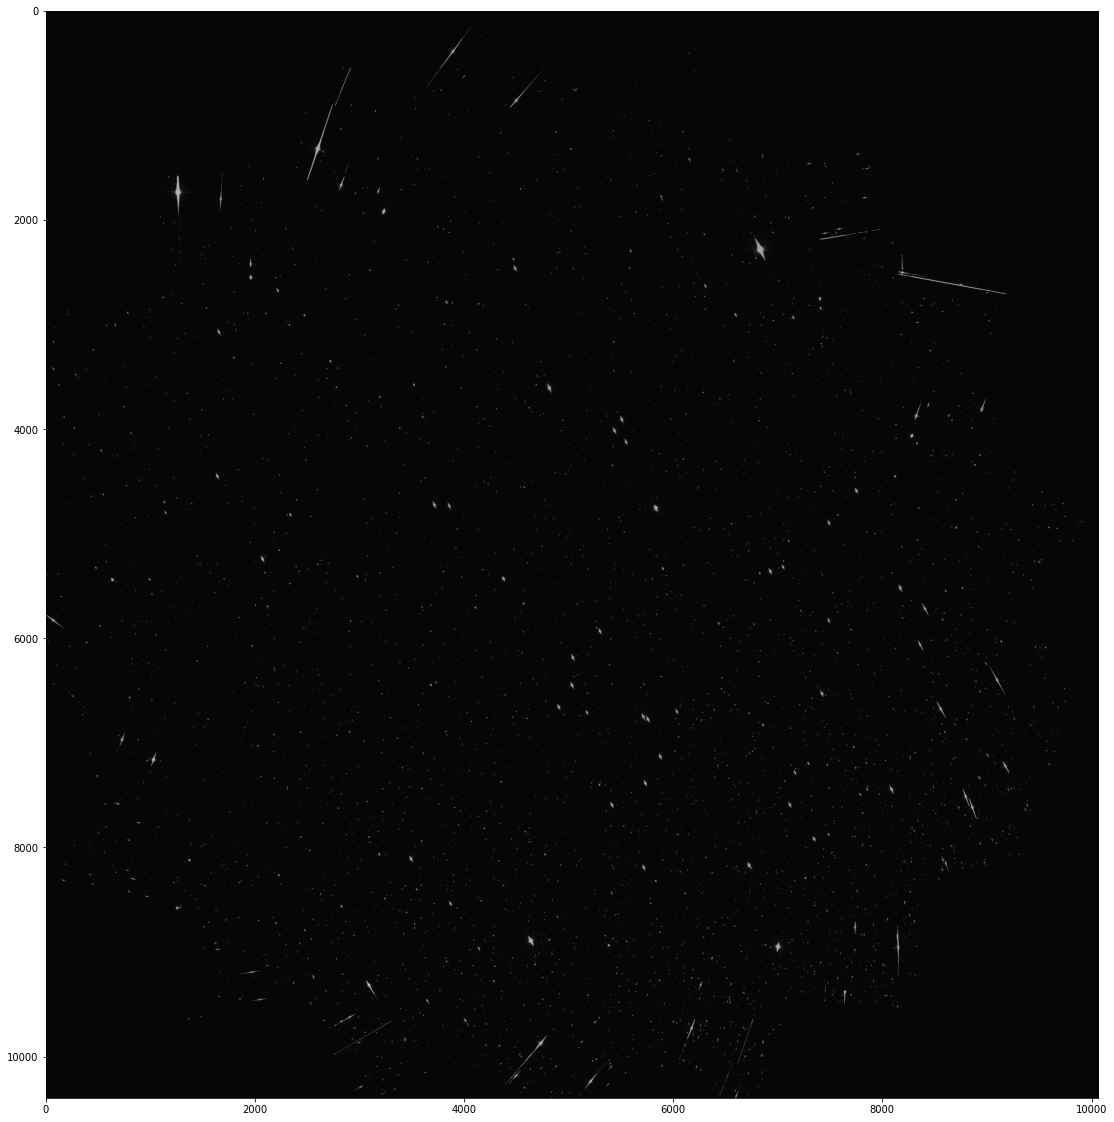

In [36]:
plt.figure(figsize = (20,20))
plt.imshow(image_data_f814w, cmap='gray');

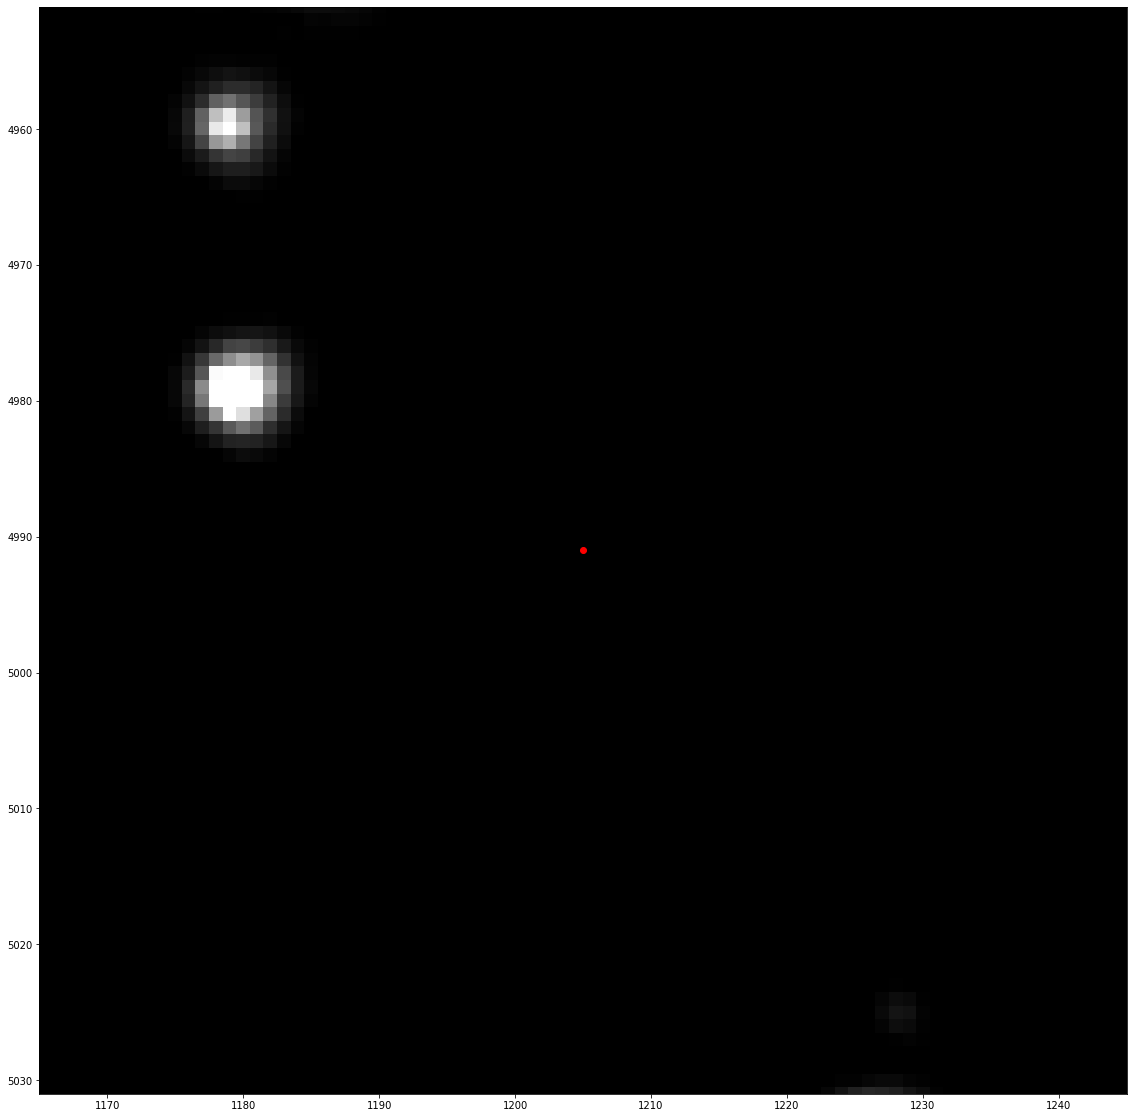

In [37]:
idx, idy = np.int32(np.floor(data.loc[data.ID == 66162,
                                      ['Xcor', 'Ycor']].values[0] + 0.5))
plt.figure(figsize = (20,20))
plt.imshow(image_data_f606w, cmap='gray', vmin=10, vmax=300)
plt.xlim(idy-40,idy+40)
plt.ylim(idx+40,idx-40)
plt.scatter(idy, idx, marker='o', c='r');

In [38]:
data[(data.Ycor < 3270) & (data.Ycor > 3240) & (data.Xcor < xmax) & (data.Xcor > xmin)]

NameError: name 'xmax' is not defined

# Calcolare il massimo dell'intensità dentro il cerchio 

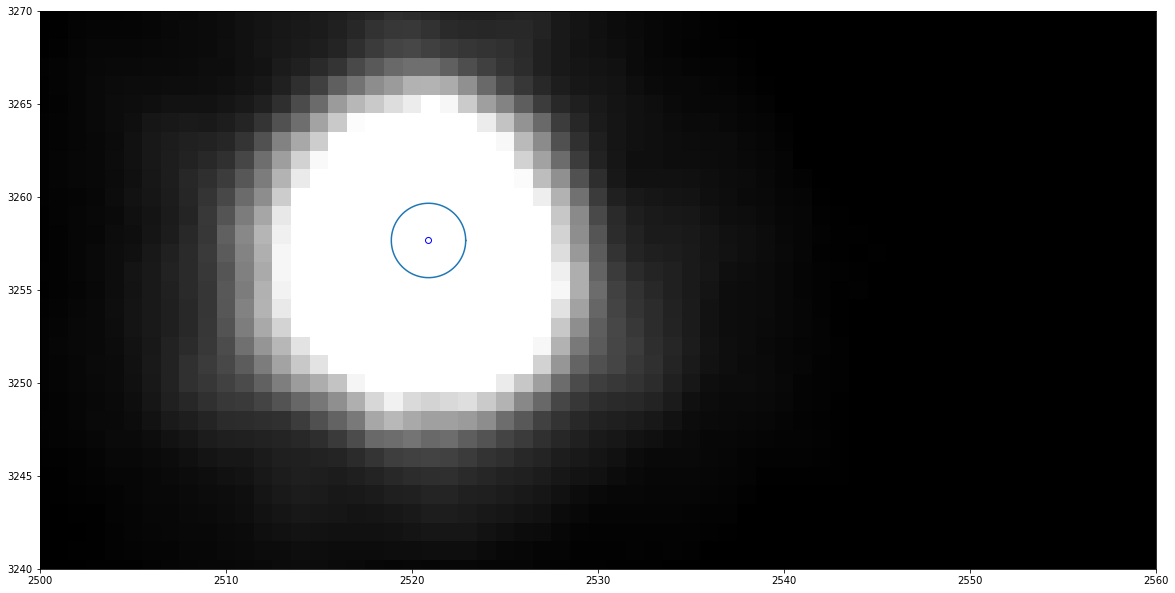

In [39]:
xmin, xmax = 2500, 2560
ymin, ymax = 3240, 3270

plt.figure(figsize = (20,20))
plt.imshow(image_data_f606w, cmap='gray',vmin=10, vmax=300)
plt.xlim((xmin, xmax))
plt.ylim((ymin, ymax))

plt.scatter(data.Xcor[Tuc],data.Ycor[Tuc], marker='o', color='g', fc='None')
plt.scatter(data.loc[data.ID == 5000267, 'Xcor'], data.loc[data.ID == 5000267, 'Ycor'], marker='o', color='b', fc='None')
ang = np.linspace(0, 2*np.pi, 1000)
plt.plot(data.loc[data.ID == 5000267, 'Xcor'].values[0] + 2*np.cos(ang),data.loc[data.ID == 5000267, 'Ycor'].values[0] + 2*np.sin(ang));

In [40]:
Circle((1,1), 1)
plt.show()

C:\Users\manue\AppData\Local\Temp/ipykernel_7764/2763846788.py:8: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


Text(0.5, 0, 'Y')

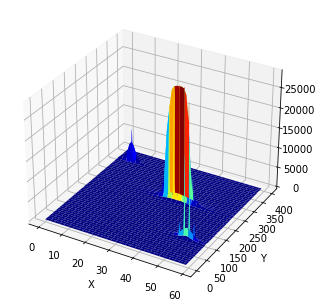

In [41]:
from mpl_toolkits.mplot3d import Axes3D

xmin, xmax = 2500, 2560
ymin, ymax = 3100, 3500

X, Y = np.mgrid[:image_data_f606w[xmin:xmax, ymin:ymax].shape[0], :image_data_f606w[xmin:xmax, ymin:ymax].shape[1]]
fig = plt.figure()
ax = Axes3D(fig)
Z = image_data_f606w[xmin:xmax, ymin:ymax]
ax.plot_surface(X, Y, Z, cmap=plt.cm.jet);
plt.xlabel('X')
plt.ylabel('Y')

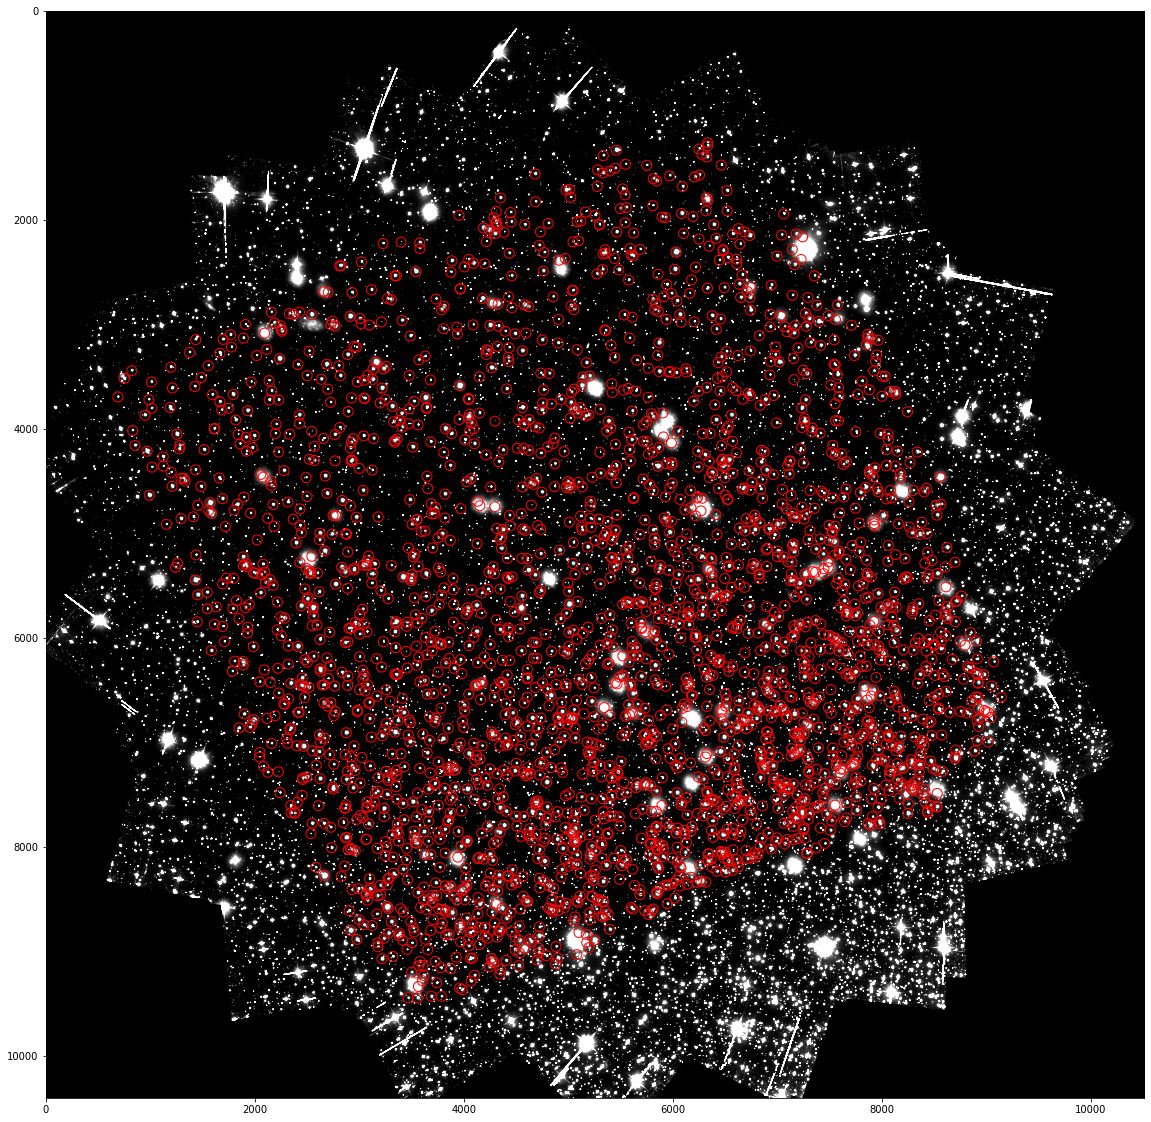

In [42]:
idx, idy = np.int32(np.floor(data.loc[data.ID == 804243, ['Xcor', 'Ycor']].values[0] + 0.5))

fig_1 = plt.figure(figsize = (20,20))
plt.imshow(image_data_f606w, cmap='gray',vmin=10, vmax=300)
#plt.xlim(4400 , 4600)
#plt.ylim(4200 , 4400)

plt.scatter(data[data.chi == 0].Xcor, data[data.chi == 0].Ycor, marker='o', color='r', fc='None', s=100);

Histogram of image data intensities

In [ ]:
%matplotlib inline

vmin = image_data_f606w.min() 
vmax = image_data_f606w.max()
print(vmin, vmax)

np.seterr(divide='ignore') #suppress the warnings raised by taking log10 of data with zeros
plt.hist(np.log10(image_data_f606w.flatten()), range=(-np.log10(abs(vmin)), np.log10(abs(vmax))), bins=100);

Filtering function of pixel values of image data

In [ ]:
def Filter(inf, sup):
    image_0 = np.copy(image)
    image_0[(image_0 < inf) | (image_0 > sup)] = 0

    fig, axs = plt.subplots(1, 2, figsize=(15,8), constrained_layout=True)
    axs = trim_axs(axs, 2)

    axs[0].imshow(image, cmap='gray', vmin=10, vmax=300)
    axs[1].imshow(image_0, cmap='gray', vmin=10, vmax=300)

In questa cella vengono identificate le stelle che hanno intensità $\in [950, 1050]$.

Al momento ci sono diverse stelle che vengono prese più volte e l'algoritmo risulta essere abbastanza lento (ottimizzarlo).

In [ ]:
'''fig, axs = plt.subplots(2, 2, figsize=(15,8), constrained_layout=True)
axs = trim_axs(axs, 4)

axs[0].imshow(image_data_f606w, cmap='gray',vmin=10, vmax=300)
axs[1].imshow(image_0, cmap='gray',vmin=1, vmax=300)
axs[1].scatter(data.loc[data.ID.isin(uniq), 'Xcor'], data.loc[data.ID.isin(uniq), 'Ycor'], marker='o', color='r', fc='None', s=20)
axs[2].imshow(image_0, cmap='gray',vmin=1, vmax=300)
axs[3].imshow(image_0, cmap='gray',vmin=10, vmax=300)'''

In [ ]:
'''image = np.copy(image_data_f606w)
idys, idxs = np.where((image > 950) & (image < 5050))
ids = []
for i in range(len(idxs)):
    tmp = (data.Ycor - idys[i]) ** 2 + (data.Xcor - idxs[i]) ** 2 <= 4
    boh = np.sum(tmp)
    if boh > 0:
        for j in data.loc[tmp, 'ID'].values:
            ids.append(j)

uniq = np.unique(ids)'''

attenzione bordi stelle più grandi 

In [ ]:
def Fit(df, id, img):
    '''
    parameters:: dataframe, id, image
    returns:: array(id, x_mean, y_mean, x_std, y_std, amplitude, theta)
    '''
    xc, yc = np.int32(df.loc[df.ID == id, ['Xcor', 'Ycor']].values[0])
    

    # Cut out smaller box around PSF
    bb = 30
    box = img[yc-bb:yc+bb,xc-bb:xc+bb]
    yp, xp = box.shape

    #plt.imshow(box, cmap='gray')

    y, x, = np.mgrid[:yp, :xp]
    f_init = models.Gaussian2D()
    
    fit_f = fitting.LevMarLSQFitter()
    
    f = fit_f(f_init, x, y, box)
    x_mean = xc-bb + f.x_mean[0]
    y_mean = yc-bb + f.y_mean[0]
    return np.array([id, x_mean, y_mean, f.x_stddev[0], f.y_stddev[0], f.amplitude[0], f.theta[0]])  

In [ ]:
if os.path.isfile("../Data/results.csv"):
    results = pd.read_csv("../Data/results.csv")
else:
    results = np.zeros((len(uniq), len(Fit(data, uniq[0], image_data_f606w))))
    for j,i in enumerate(uniq):
        results[j, :]= Fit(data, i, image_data_f606w)

    results = pd.DataFrame(results, columns=['ID', 'x_mean', 'y_mean', 'x_std', 'y_std', 'amplitude', 'theta'])
    results = results[results.theta != 0]
    results.to_csv("../Data/results.csv", index=False)

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15,8), constrained_layout=True)
axs = trim_axs(axs, 4)

tmp = results[(results.x_std/results.x_mean < 0.05) & (results.y_std/results.y_mean < 0.05) & (results.amplitude < 1100) & (results.amplitude > 900)]

axs[0].hist(tmp['amplitude'], bins=50, label='amplitude')
axs[0].legend();

axs[1].hist(tmp['theta'], bins=50, label='theta')
axs[1].legend();

axs[2].hist(tmp['x_std']/tmp['x_mean'], bins=50, label='x_std')
axs[2].legend();

axs[3].hist(tmp['y_std']/tmp['y_mean'], bins=50, label='y_std')
axs[3].legend();

In [ ]:
results['y_std'].min(), results['y_std'].max()

In [ ]:
results[(results.x_std/results.x_mean < 0.05) & (results.y_std/results.y_mean < 0.05) & (results.amplitude < 1100) & (results.amplitude > 900)]

In [ ]:
'''%matplotlib inline

fig, axs = plt.subplots(1, 2, figsize=(15,8), constrained_layout=True)
axs = trim_axs(axs, 2)

axs[0].imshow(image_data_f606w, cmap='gray',vmin=10, vmax=300)
axs[1].imshow(image_0, cmap='gray', vmin=10, vmax=300);
#plt.xlim(4400 , 4600)
#plt.ylim(4200 , 4400)

#plt.scatter(data.loc[Tuc, 'Xcor'], data.loc[Tuc, 'Ycor'], marker='o', color='r', fc='None', s=10);'''

In [ ]:
fig_1 = plt.figure(figsize = (20,20))
plt.imshow(image_data_f606w, cmap='gray',vmin=10, vmax=300)
plt.xlim(4465 , 4515)
plt.ylim(4290 , 4335)

In [ ]:
plt.imshow(image_data_f606w[4290:4335,4465:4515], cmap='gray',vmin=10, vmax=300)

xlim(4400 , 4600)
ylim(4200 , 4400)
Intervallo interessante per il calcolo della psf, in particolare sono interessanti le stelle in 
[4465 , 4515]x[4290 , 4335]



In [ ]:
box = image_data_f606w[4290:4335,4465:4515]
yp, xp = box.shape

y, x, = np.mgrid[:yp, :xp]
f_init = models.Gaussian2D()

fit_f = fitting.LevMarLSQFitter()

f = fit_f(f_init, x, y, box)

plt.figure(figsize=(8, 2.5))
plt.subplot(1, 3, 1)
plt.imshow(box)
plt.title("Data")
plt.subplot(1, 3, 2)
plt.imshow(f(x, y))
plt.title("Model")
plt.subplot(1, 3, 3)
plt.imshow(box - f(x, y))
plt.title("Residual")
plt.show()

In [ ]:
f

In [ ]:
cents = np.where(image_data_f606w == np.max(image_data_f606w[4000:6000, 4000:6000]))
xc = int(cents[1][0])
yc = int(cents[0][0])

# Cut out smaller box around PSF
bb = 30
box = image_data_f606w[yc-bb-10:yc+bb+10,xc-bb+10:xc+bb]
yp, xp = box.shape

#plt.imshow(box, cmap='gray')

y, x, = np.mgrid[:yp, :xp]
f_init = models.Gaussian2D()

fit_f = fitting.LevMarLSQFitter()

f = fit_f(f_init, x, y, box)

plt.figure(figsize=(8, 2.5))
plt.subplot(1, 3, 1)
plt.imshow(box)
plt.title("Data")

plt.subplot(1, 3, 2)
plt.imshow(f(x, y))
plt.title("Model")

plt.subplot(1, 3, 3)
plt.imshow(box - f(x, y))
plt.title("Residual")

plt.show()

In [ ]:
print(cents, box.max())

In [ ]:
f

In [ ]:
idx, idy = np.int32(np.floor(data.loc[data.ID == 804243, ['Xcor', 'Ycor']].values[0] + 0.5))

fig_1 = plt.figure(figsize = (20,20))
plt.imshow(image_data_f606w, cmap='gray',vmin=10, vmax=300)
plt.xlim(idx + 100 , idx - 100)
plt.ylim(idy - 100 , idy + 100)

plt.scatter(idx, idy, marker='o', color='r', fc='None', s=100);

In [ ]:
from scipy.signal import find_peaks, peak_widths

idx, idy = np.int32(np.floor(data.loc[data.ID == 804243, ['Xcor', 'Ycor']].values[0] + 0.5))

xcut=image_data_f606w[:, idy]
xpos=np.arange(0, image_data_f606w.shape[0],1)

peaks_x, _ = find_peaks(xcut, prominence=450, distance=35)
peaks_x, _ = find_peaks(xcut, prominence=450, distance=9)

ycut=image_data_f606w[idx,:]
ypos=np.arange(0, image_data_f606w.shape[1],1)

result = peak_widths(xcut, peaks_x, rel_height=0.98)

fig_1 = plt.figure(figsize = (20,12))
plt.subplot(311)
plt.plot(xcut,marker='.')
plt.plot(peaks_x, xcut[peaks_x], "x")
plt.scatter(idx, 30000, c='r')
plt.ylabel('Intensity [ADU]')
plt.xlabel('X-Axis Position [pixel]')


peaks_y, _ = find_peaks(ycut, prominence=450, distance=35)

plt.subplot(312)
plt.plot(ycut,marker='.')
plt.scatter(idy, 30000, c='r')
plt.plot(peaks_y, ycut[peaks_y], "x")
plt.ylabel('Intensity [ADU]')
plt.xlabel('Y-Axis Position [pixel]')


plt.subplot(325)
xmin=2950
xmax=3000
plt.plot(xpos[xmin:xmax],xcut[xmin:xmax],marker='.')
plt.ylabel('Intensity [ADU]')
plt.xlabel('X-Axis Position [pixel]')


plt.subplot(326)
boh = -3
xmin=int(result[2][boh])
xmax=int(result[3][boh]) + 2
plt.plot(xpos[xmin:xmax],xcut[xmin:xmax],marker='.')
plt.vlines(result[2][boh], 0, xcut[peaks_x[boh]] * 0.2, colors='r')
plt.vlines(result[3][boh], 0, xcut[peaks_x[boh]] * 0.2, colors='r')
plt.ylabel('Intensity [ADU]')
plt.xlabel('X-Axis Position [pixel]')
plt.show()

In [ ]:
result

In [ ]:
def cutting(image, id, df, prominence=450, distance=35):

    idx, idy = np.int32(np.round(df.loc[df.ID == id, ['Xcor', 'Ycor']].values[0]))

    xcut=image[:, idy]
    
    ycut=image[idx,:]
    
    peaks_x, _ = find_peaks(xcut, prominence=prominence, distance=distance)
    peaks_y, _ = find_peaks(ycut, prominence=prominence, distance=distance)

    return idx, idy, xcut, ycut, peaks_x, peaks_y

In [ ]:
idx, idy, xcut, ycut, peaks_x, peaks_y = cutting(image_data_f606w, 804243, data)

In [ ]:
peaks_x

In [ ]:
data.loc[(np.round(data.Ycor) == idy)]

In [ ]:
fig_1 = plt.figure(figsize = (20,12))
plt.subplot(311)
plt.plot(xcut,marker='.')
plt.plot(peaks_x, xcut[peaks_x], "x")
plt.scatter(idx, 30000, c='r')
plt.ylabel('Intensity [ADU]')
plt.xlabel('X-Axis Position [pixel]')


plt.subplot(312)
plt.plot(ycut,marker='.')
plt.scatter(idy, 30000, c='r')
plt.plot(peaks_y, ycut[peaks_y], "x")
plt.ylabel('Intensity [ADU]')
plt.xlabel('Y-Axis Position [pixel]')


plt.subplot(325)
xmin=2950
xmax=3000
plt.plot(np.arange(xmin,xmax),xcut[xmin:xmax],marker='.')
plt.ylabel('Intensity [ADU]')
plt.xlabel('X-Axis Position [pixel]')


plt.subplot(326)
xmin=5470
xmax=5520
plt.plot(np.arange(xmin,xmax),xcut[xmin:xmax],marker='.')
plt.ylabel('Intensity [ADU]')
plt.xlabel('X-Axis Position [pixel]')
plt.show()

In [ ]:
fig_1 = plt.figure(figsize = (20,20))
plt.imshow(image_data_f606w, cmap='gray',vmin=10, vmax=300)

peaks_y_tmp = np.full(len(peaks_x), idy)
plt.scatter(peaks_x, peaks_y_tmp, marker='o', color='r', fc='None', s=100)
plt.xlim(2000, 8000)
plt.ylim(9500, 9000);

In [ ]:
def find_nearest(dataframe, value, column):
    '''
    dataframe
    value to search the nearest value in the dataframe
    column index, it must be 1 or 2 (Xcor or Ycor)
    '''
    
    index = np.abs(data.iloc[:, column] - value).argmin()
    return dataframe.iloc[index, [1,2]].to_numpy()

In [ ]:
np.where(image_data_f606w == xcut[peaks_x].max())

In [ ]:
data.iloc[np.abs(data.Xcor - np.where(image_data_f606w == xcut[peaks_x].max())[0]).argmin(), :]

In [ ]:
find_nearest(data, 7648, 1)

<font color=red>To do:
* trovare ID dei pti nel grafico della sharpness che hanno magnitudine negativa 
* fare plot dei centri X_cor, Y_cor e vedere se coincidono con posizioni stelle nelle due immagini scaricate
* fare tagli di magnitudine per visualizzazione stelle, partendo da valori più alti (30, 25, 20, 15) e vedere se c'è somiglianza

</font>

# Referenze
* sito provenienza datasets: https://archive.stsci.edu/prepds/deep47tuc/#dataaccess
* doc astropy: https://docs.astropy.org/en/stable/io/fits/
    * example astropy usage: http://learn.astropy.org/FITS-images.html